# Atlas notebooks

> This notebook reproduces some of the common regional figures of the IPCC AR6-WGI Atlas chapter. This and other notebooks are available at https://github.com/IPCC-WG1/Atlas for reproducibility and reusability purpose.

## Bias adjustment of daily mean, minimum and maximum temperature for climate indices calculation

*29/6/2021*

**A. Casanueva** (Santander Meteorology Group. Dept. Applied Mathematics and Compute Science, University of Cantabria, Santander, Spain).

**EDIT where this is used** TX35 in interactive Atlas. Cross-Chapter Box 10.2: Issues in bias adjustment and Casanueva et al. 2020.


The ISIMIP3 method (Lange 2019) requires daily mean, minimum and maximum temperature for the correction of maximum and minimum temperature, which are obtained from the correction of the amplitude and skewness of the diurnal temperature cycle. In this example, a single global climate model (CMIP5_EC-EARTH_r12i1p1) is bias-adjusted using the EWEMBI observational dataset for the Mediterranean region.

### Load packages
This notebook is based on R programming language and requires packages:

 * `loadeR` to load climate model and observational datasets (Iturbide et al. 2019).
 * `climate4R.UDG` to access harmonized climate data via the [Santander Met Group User Data Gateway](http://meteo.unican.es/udg-tap/).
 * `transformeR` to manipulate climate data (Iturbide et al. 2019).
 * `downscaleR` to adjust systematic model biases (Bedia et al. 2020).
 * `climate4R.indices`to compute climate indices (Iturbide et al. 2019).
 * `visualizeR`to produce graphical representations of the results (Frías et al. 2018).
 * `rgdal` to work with spatial data (Bivand et al., 2018).

In [1]:
# devtools::install_github('SantanderMetGroup/climate4R.UDG') # it will be out of the conda distribution
# install.packages("rgdal")
library(loadeR) 
library(climate4R.UDG) 
library(downscaleR)
library(climate4R.indices)
library(visualizeR)
library(rgdal)

Loading required package: rJava

Loading required package: loadeR.java

Java version 11x amd64 by Oracle Corporation detected

NetCDF Java Library v4.6.0-SNAPSHOT (23 Apr 2015) loaded and ready

Loading required package: climate4R.UDG

climate4R.UDG version 0.2.2 (2021-05-28) is loaded

Please use 'citation("climate4R.UDG")' to cite this package.

loadeR version 1.7.0 (2020-09-18) is loaded

Please use 'citation("loadeR")' to cite this package.

Loading required package: transformeR




    _______   ____  ___________________  __  ________ 
   / ___/ /  / /  |/  / __  /_  __/ __/ / / / / __  / 
  / /  / /  / / /|_/ / /_/ / / / / __/ / /_/ / /_/_/  
 / /__/ /__/ / /  / / __  / / / / /__ /___  / / \ \ 
 \___/____/_/_/  /_/_/ /_/ /_/  \___/    /_/\/   \_\ 
 
      github.com/SantanderMetGroup/climate4R



transformeR version 2.1.0 (2021-03-17) is loaded


Get the latest stable version (2.1.1) using <devtools::install_github('SantanderMetGroup/transformeR')>

Please see 'citation("transformeR")' to cite this package.

downscaleR version 3.3.2 (2020-06-05) is loaded

Please use 'citation("downscaleR")' to cite this package.

climate4R.indices version 0.1.0 (2019-10-08) is loaded

Use 'indexShow()' for an overview of the available climate indices and circIndexShow() for the circulation indices.

NOTE: use package climate4R.climdex to calculate ETCCDI indices.


Attaching package: ‘climate4R.indices’


The following object is masked from ‘package:transformeR’:

    lambWT


visualizeR version 1.6.0 (2020-05-23) is loaded


Get the latest stable version (1.6.1) using <devtools::install_github('SantanderMetGroup/visualizeR')>

Please see 'citation("visualizeR")' to cite this package.

Loading required package: sp

rgdal: version: 1.5-16, (SVN revision 1050)
Geospatial Data Abstraction Library

### Parameter settings

Assign parameters to select season, baseline period, future periods and scenario, as well as the datasets' names (observations and global climate model simulations for the historical and future scenarios).

In [2]:
years.hist <- 1986:2005
years.rcp <- 2041:2060
season <- 6:8 # we focus on summer months for the calculation of extreme temperature indices

# UDG codes for the selected datasets (check other available harmonized datasets with ?UDG.datasets):
dataset.obs <- "PIK_Obs-EWEMBI" 
dataset.hist <- "CMIP5_EC-EARTH_r12i1p1_historical"
dataset.rcp <- "CMIP5_EC-EARTH_r12i1p1_rcp85"

### Prepare IPCC region

For illustrative purpuses, this example uses one IPCC region only, namely the Mediterranean region ('MED'). See the specific notebook for more details in how to work with IPCC regions (see **ADD notebook LINK** and Iturbide et al. 2020).

Loading objects:
  IPCC_WGI_reference_regions_v4


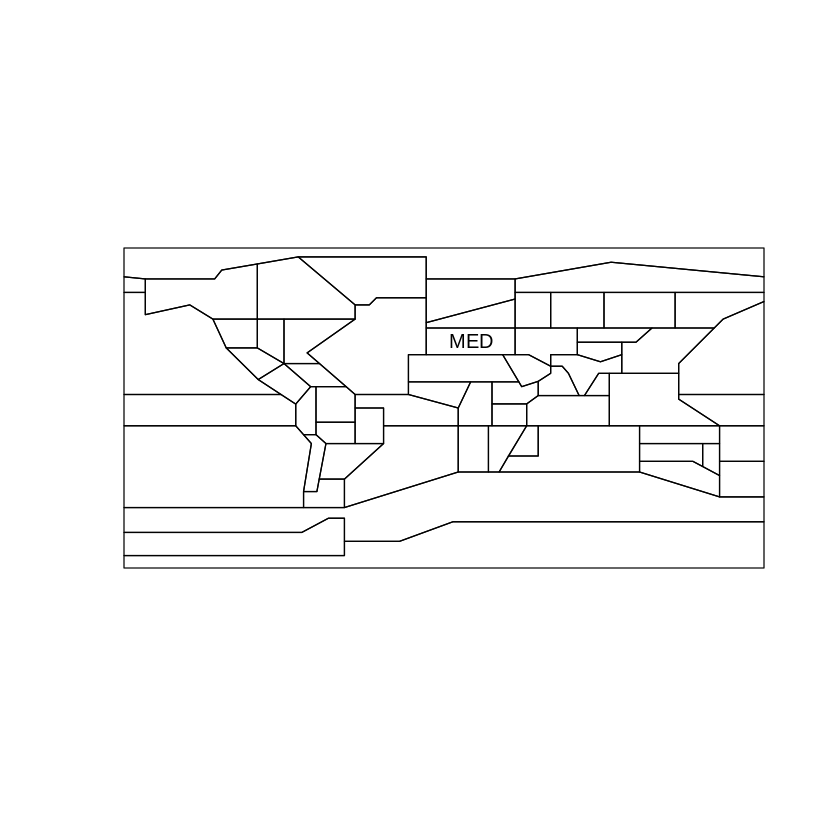

In [3]:
load("../reference-regions/IPCC-WGI-reference-regions-v4_R.rda", verbose = TRUE)
refregions <- as(IPCC_WGI_reference_regions_v4, "SpatialPolygons")
region <- refregions["MED"]
bb <- bbox(region) # region boundaries, which will be used to read the exemplary data.
lons <- bb[1,] 
lats <- bb[2,]

plot(refregions)
text(x = coordinates(region)[,1],
     y = coordinates(region)[,2],
     labels = names(region), cex = 1)

### Load datasets
First, we load daily mean temperature for the observations and the model (historical and future scenario), by using their UDG code and the temporal and spatial extents defined above:

In [4]:
credentials <- read.table("creden.txt", stringsAsFactors = FALSE)
loginUDG(username = credentials$V1[1], password = credentials$V1[2]) # ONLY NEEDED FOR THE OBSERVATIONS! CHECK
y.tas <- loadGridData(dataset = dataset.obs, var = "tas", years = years.hist, latLim =lats, lonLim=lons, season=season)
x.tas <- loadGridData(dataset = dataset.hist, var = "tas", years = years.hist, latLim = lats, lonLim=lons, season=season)
newdata.tas <- loadGridData(dataset = dataset.rcp, var = "tas", years = years.rcp, latLim = lats, lonLim=lons, season=season)

[2021-06-30 08:22:50] Setting credentials...

[2021-06-30 08:22:50] Success!
Go to <http://www.meteo.unican.es/udg-tap/home> for details on your authorized groups and datasets

NOTE: Accessing harmonized data from a public UDG dataset

[2021-06-30 08:22:51] Defining harmonization parameters for variable "tas"

[2021-06-30 08:22:51] Opening dataset...

[2021-06-30 08:22:54] The dataset was successfuly opened

[2021-06-30 08:22:54] Defining geo-location parameters

[2021-06-30 08:22:54] Defining time selection parameters

[2021-06-30 08:22:54] Retrieving data subset ...

[2021-06-30 08:23:52] Done

NOTE: Accessing harmonized data from a public UDG dataset

[2021-06-30 08:23:52] Defining harmonization parameters for variable "tas"

[2021-06-30 08:24:53] Opening dataset...

[2021-06-30 08:25:08] The dataset was successfuly opened

[2021-06-30 08:25:08] Defining geo-location parameters

[2021-06-30 08:25:08] Defining time selection parameters

[2021-06-30 08:25:08] Retrieving data subset ..

The same for daily minimum temperature:

In [5]:
y.tasmin <- loadGridData(dataset = dataset.obs, var = "tasmin", years = years.hist, latLim =lats, lonLim=lons, season=season)
x.tasmin <- loadGridData(dataset = dataset.hist, var = "tasmin", years = years.hist, latLim = lats, lonLim=lons, season=season)
newdata.tasmin <- loadGridData(dataset = dataset.rcp, var = "tasmin", years = years.rcp, latLim = lats, lonLim=lons, season=season)

NOTE: Accessing harmonized data from a public UDG dataset

[2021-06-30 08:28:35] Defining harmonization parameters for variable "tasmin"

[2021-06-30 08:28:35] Opening dataset...

[2021-06-30 08:28:36] The dataset was successfuly opened

[2021-06-30 08:28:36] Defining geo-location parameters

[2021-06-30 08:28:36] Defining time selection parameters

[2021-06-30 08:28:36] Retrieving data subset ...

[2021-06-30 08:29:33] Done

NOTE: Accessing harmonized data from a public UDG dataset

[2021-06-30 08:29:33] Defining harmonization parameters for variable "tasmin"

[2021-06-30 08:29:33] Opening dataset...

[2021-06-30 08:29:46] The dataset was successfuly opened

[2021-06-30 08:29:46] Defining geo-location parameters

[2021-06-30 08:29:46] Defining time selection parameters

[2021-06-30 08:29:46] Retrieving data subset ...

[2021-06-30 08:30:56] Done

NOTE: Accessing harmonized data from a public UDG dataset

[2021-06-30 08:30:56] Defining harmonization parameters for variable "tasmin"

[2

And maximum temperature:

In [6]:
y.tasmax <- loadGridData(dataset = dataset.obs, var = "tasmax", years = years.hist, latLim =lats, lonLim=lons, season=season)
x.tasmax <- loadGridData(dataset = dataset.hist, var = "tasmax", years = years.hist, latLim = lats, lonLim=lons, season=season)
newdata.tasmax <- loadGridData(dataset = dataset.rcp, var = "tasmax", years = years.rcp, latLim = lats, lonLim=lons, season=season)

NOTE: Accessing harmonized data from a public UDG dataset

[2021-06-30 08:32:18] Defining harmonization parameters for variable "tasmax"

[2021-06-30 08:32:18] Opening dataset...

[2021-06-30 08:32:18] The dataset was successfuly opened

[2021-06-30 08:32:18] Defining geo-location parameters

[2021-06-30 08:32:18] Defining time selection parameters

[2021-06-30 08:32:19] Retrieving data subset ...

[2021-06-30 08:33:14] Done

NOTE: Accessing harmonized data from a public UDG dataset

[2021-06-30 08:33:14] Defining harmonization parameters for variable "tasmax"

[2021-06-30 08:33:15] Opening dataset...

[2021-06-30 08:33:28] The dataset was successfuly opened

[2021-06-30 08:33:28] Defining geo-location parameters

[2021-06-30 08:33:28] Defining time selection parameters

[2021-06-30 08:33:28] Retrieving data subset ...

[2021-06-30 08:34:41] Done

NOTE: Accessing harmonized data from a public UDG dataset

[2021-06-30 08:34:41] Defining harmonization parameters for variable "tasmax"

[2

### Data preparation
Due to the spatial mismatch between the model and observations, we upscale the observations from their original grid (0.5$^\circ$x0.5$^\circ$) to a 1$^\circ$x1$^\circ$ grid. This way, they are also on a similar resolution to the model (1.125$^\circ$) (see a discussion on this in Casanueva et al. 2020). 

In [7]:
y.tas <- redim(upscaleGrid(y.tas, times = 2, aggr.fun = list(FUN="mean", na.rm=TRUE)), drop=TRUE)
y.tasmax <- redim(upscaleGrid(y.tasmax, times = 2, aggr.fun = list(FUN="mean", na.rm=TRUE)), drop=TRUE)
y.tasmin <- redim(upscaleGrid(y.tasmin, times = 2, aggr.fun = list(FUN="mean", na.rm=TRUE)), drop=TRUE)

We now interpolate the model data onto the observations grid with `interpGrid` and assure that both datasets have the same grid with `intersectGrid`. These steps are applied to the three variables and the two simulations (historical and RCP8.5). **this is not neeeded if an issue with the interpolation in biasCorrection is corrected. CHECK**

In [8]:
x.tas <- interpGrid(x.tas, new.coordinates = getGrid(y.tas), method="nearest")
newdata.tas <- interpGrid(newdata.tas, new.coordinates = getGrid(y.tas), method="nearest")

obs.tas <- intersectGrid(x.tas, y.tas, type="spatial", which.return=2)
hist.tas <- intersectGrid(x.tas, y.tas, type="spatial", which.return=1)
rcp.tas <- intersectGrid(newdata.tas, y.tas, type="spatial", which.return=1)

# the same for minimum temperature
x.tasmin <- interpGrid(x.tasmin, new.coordinates = getGrid(y.tasmin), method="nearest")
newdata.tasmin <- interpGrid(newdata.tasmin, new.coordinates = getGrid(y.tasmin), method="nearest")

obs.tasmin <- intersectGrid(x.tasmin, y.tasmin, type="spatial", which.return=2)
hist.tasmin <- intersectGrid(x.tasmin, y.tasmin, type="spatial", which.return=1)
rcp.tasmin <- intersectGrid(newdata.tasmin, y.tasmin, type="spatial", which.return=1)

# the same for maximum temperature
x.tasmax <- interpGrid(x.tasmax, new.coordinates = getGrid(y.tasmax), method="nearest")
newdata.tasmax <- interpGrid(newdata.tasmax, new.coordinates = getGrid(y.tasmax), method="nearest")

obs.tasmax <- intersectGrid(x.tasmax, y.tasmax, type="spatial", which.return=2)
hist.tasmax <- intersectGrid(x.tasmax, y.tasmax, type="spatial", which.return=1)
rcp.tasmax <- intersectGrid(newdata.tasmax, y.tasmax, type="spatial", which.return=1)

[2021-06-30 08:37:02] Calculating nearest neighbors...

[2021-06-30 08:37:02] Performing nearest interpolation... may take a while

[2021-06-30 08:37:02] Done

[2021-06-30 08:37:02] Calculating nearest neighbors...

[2021-06-30 08:37:02] Performing nearest interpolation... may take a while

[2021-06-30 08:37:02] Done

[2021-06-30 08:37:02] Calculating nearest neighbors...

[2021-06-30 08:37:02] Performing nearest interpolation... may take a while

[2021-06-30 08:37:03] Done

[2021-06-30 08:37:03] Calculating nearest neighbors...

[2021-06-30 08:37:03] Performing nearest interpolation... may take a while

[2021-06-30 08:37:03] Done

[2021-06-30 08:37:03] Calculating nearest neighbors...

[2021-06-30 08:37:03] Performing nearest interpolation... may take a while

[2021-06-30 08:37:03] Done

[2021-06-30 08:37:03] Calculating nearest neighbors...

[2021-06-30 08:37:03] Performing nearest interpolation... may take a while

[2021-06-30 08:37:03] Done



The following plot illustrate the model biases in the mean temperatures:

[2021-06-30 08:38:45] - Computing climatology...

[2021-06-30 08:38:45] - Done.

[2021-06-30 08:38:45] - Computing climatology...

[2021-06-30 08:38:45] - Done.

[2021-06-30 08:38:45] - Computing climatology...

[2021-06-30 08:38:45] - Done.

[2021-06-30 08:38:45] - Computing climatology...

[2021-06-30 08:38:45] - Done.

[2021-06-30 08:38:45] - Computing climatology...

[2021-06-30 08:38:45] - Done.

[2021-06-30 08:38:45] - Computing climatology...

[2021-06-30 08:38:45] - Done.



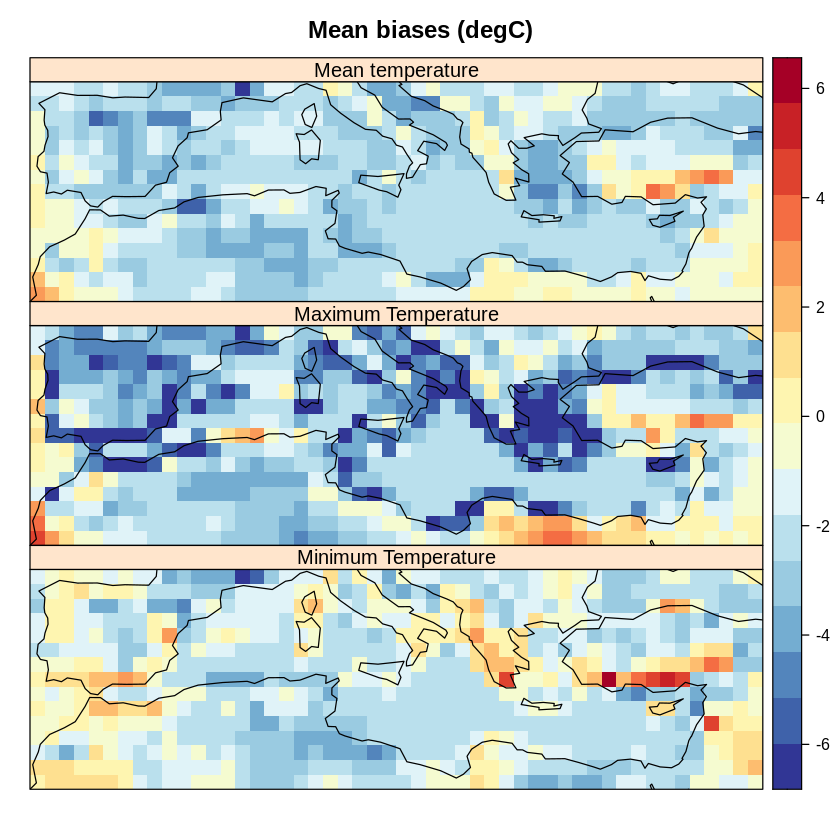

In [11]:
bias.tas <- gridArithmetics(climatology(hist.tas), climatology(obs.tas), operator = c("-"))
bias.tasmax <- gridArithmetics(climatology(hist.tasmax), climatology(obs.tasmax), operator = c("-"))
bias.tasmin <- gridArithmetics(climatology(hist.tasmin), climatology(obs.tasmin), operator = c("-"))

spatialPlot(makeMultiGrid(bias.tas, bias.tasmax, bias.tasmin, skip.temporal.check=TRUE), backdrop.theme="coastline", 
            names.attr=c("Mean temperature","Maximum Temperature","Minimum Temperature"),
            main="Mean biases (degC)", as.table=TRUE, set.min=-6, set.max=6, rev.colors=TRUE)

And annual TX35  (number of days with maximum temperature above 35$^\circ$C), obtained with `indexGrid`:

In [12]:
index.obs <- redim(indexGrid(tx = obs.tasmax, index.code = "TXth", th = 35, time.resolution = "year"), drop = TRUE)
index.raw <- redim(indexGrid(tx = hist.tasmax, index.code = "TXth", th = 35, time.resolution = "year"), drop = TRUE)

[2021-06-30 08:40:23] Calculating TXth ...

[2021-06-30 08:40:23] Done

[2021-06-30 08:40:23] Calculating TXth ...

[2021-06-30 08:40:23] Done



Calculate multi-year means with `climatology` and plot the bias:

[2021-06-30 08:41:10] - Computing climatology...

[2021-06-30 08:41:10] - Done.

[2021-06-30 08:41:10] - Computing climatology...

[2021-06-30 08:41:10] - Done.



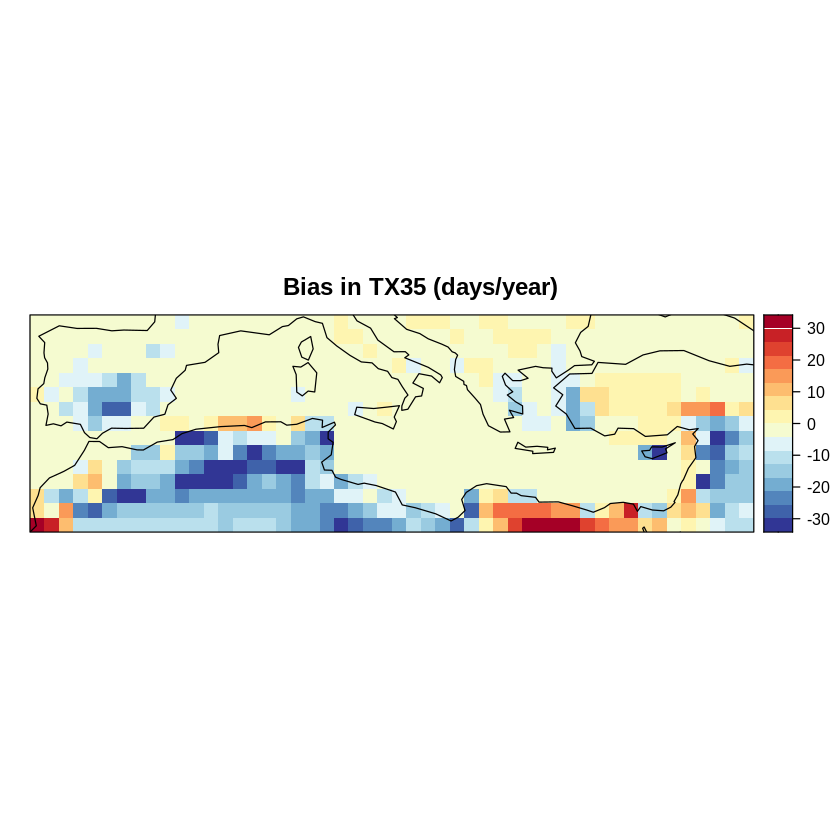

In [14]:
tx35.obs <- climatology(index.obs)
tx35.raw <- climatology(index.raw)
bias.tx35 <- gridArithmetics(tx35.raw, tx35.obs, operator = c("-"))
spatialPlot(bias.tx35, backdrop.theme="coastline", main="Bias in TX35 (days/year)", set.min=-30, set.max=30, rev.colors=TRUE)

### Bias adjustment
Bias adjusment of temperatures with ISIMIP3 consists of three steps: 1) adjustment of daily mean temperature, 2) adjustment of the temperature range and 3) adjustment of the temperature skewness. 

First, we calculate the temperature range and skewness for the observations and (historical and future) simulations, performing simple arithmetics with `GridArithmetics`:

In [15]:
obs.range <- gridArithmetics(obs.tasmax, obs.tasmin, operator = c("-"))
hist.range <- gridArithmetics(hist.tasmax, hist.tasmin, operator = c("-"))
rcp.range <- gridArithmetics(rcp.tasmax,rcp.tasmin, operator = c("-"))
obs.skew <- gridArithmetics(gridArithmetics(obs.tas, obs.tasmin, operator = "-"), obs.range, operator = "/")
hist.skew <- gridArithmetics(gridArithmetics(hist.tas,hist.tasmin, operator = "-"), hist.range, operator = "/")
rcp.skew <- gridArithmetics(gridArithmetics(rcp.tas, rcp.tasmin, operator = "-"), rcp.range, operator = "/")

Next, we perform bias adjustment of daily mean temperature. Both the future and the historical simulations are adjusted:

In [16]:
isimip3.args = list(lower_bound =  c(NULL),lower_threshold =  c(NULL), upper_bound =  c(NULL), 
                    upper_threshold =  c(NULL),  randomization_seed =  NULL, 
                    detrend =  array(data  =  TRUE, dim = 1), rotation_matrices =  c(NULL), 
                    n_quantiles = 50, distribution =  c("normal"), trend_preservation = array(data  =  "additive", dim = 1), 
                    adjust_p_values = array(data  =  FALSE, dim = 1), if_all_invalid_use =  c(NULL), 
                    invalid_value_warnings = FALSE)

bc.tas <- biasCorrection(y = obs.tas, x = hist.tas, newdata = rcp.tas, "precipitation" = FALSE, 
                         "isimip3.args" = isimip3.args, "method"="isimip3")

bc.tas.hist <- biasCorrection(y = obs.tas, x = hist.tas, newdata = hist.tas, "precipitation" = FALSE, 
                         "isimip3.args" = isimip3.args, "method"="isimip3")

Time difference of 1 days

Time difference of 1 days

Time difference of 1 days

[2021-06-30 08:41:44] Argument precipitation is set as FALSE, please ensure that this matches your data.

[2021-06-30 08:41:46] Number of windows considered: 1...

[2021-06-30 08:41:46] Bias-correcting 1 members separately...

[2021-06-30 08:43:00] Done.

Time difference of 1 days

Time difference of 1 days

Time difference of 1 days

[2021-06-30 08:43:02] Argument precipitation is set as FALSE, please ensure that this matches your data.

[2021-06-30 08:43:04] Number of windows considered: 1...

[2021-06-30 08:43:04] Bias-correcting 1 members separately...

[2021-06-30 08:44:14] Done.



Bias ajustment of temperature range:

In [17]:
isimip3.range.args  =  list(lower_bound =  c(0), lower_threshold =  c(0.01), upper_bound =  c(NULL), 
                            upper_threshold =  c(NULL), randomization_seed =  NULL, 
                            detrend =  array(data  =  FALSE, dim = 1), rotation_matrices =  c(NULL), 
                            n_quantiles = 50, distribution =  c("rice"), trend_preservation = array(data = "mixed", dim=1),
                            adjust_p_values = array(data  =  FALSE, dim = 1), if_all_invalid_use =  c(NULL), 
                            invalid_value_warnings = FALSE)
bc.range <- biasCorrection(y = obs.range, x = hist.range, newdata = rcp.range, "precipitation" = FALSE, 
                           "isimip3.args" = isimip3.range.args, "method"="isimip3")

bc.range.hist <- biasCorrection(y = obs.range, x = hist.range, newdata = hist.range, "precipitation" = FALSE, 
                           "isimip3.args" = isimip3.range.args, "method"="isimip3")

Time difference of 1 days

Time difference of 1 days

Time difference of 1 days

[2021-06-30 08:44:20] Argument precipitation is set as FALSE, please ensure that this matches your data.

[2021-06-30 08:44:22] Number of windows considered: 1...

[2021-06-30 08:44:22] Bias-correcting 1 members separately...

[2021-06-30 08:45:24] Done.

Time difference of 1 days

Time difference of 1 days

Time difference of 1 days

[2021-06-30 08:45:26] Argument precipitation is set as FALSE, please ensure that this matches your data.

[2021-06-30 08:45:28] Number of windows considered: 1...

[2021-06-30 08:45:28] Bias-correcting 1 members separately...

[2021-06-30 08:46:29] Done.



And bias adjustment of temperature skewness:

In [18]:
isimip3.skew.args  =  list(lower_bound =  c(0), lower_threshold =  c(0.0001), upper_bound =  c(1), 
                           upper_threshold =  c(0.9999), randomization_seed =  NULL,
                           detrend =  array(data  =  FALSE, dim = 1), rotation_matrices =  c(NULL), 
                           n_quantiles = 50, distribution =  c("beta"), trend_preservation = array(data = "bounded", dim = 1), 
                           adjust_p_values = array(data  =  FALSE, dim = 1), if_all_invalid_use  =  c(NULL),
                           invalid_value_warnings  =  FALSE)
bc.skew <- biasCorrection(y = obs.skew, x = hist.skew, newdata = rcp.skew, "precipitation" = FALSE, 
                          "isimip3.args" = isimip3.skew.args, "method"="isimip3")

bc.skew.hist <- biasCorrection(y = obs.skew, x = hist.skew, newdata = hist.skew, "precipitation" = FALSE, 
                          "isimip3.args" = isimip3.skew.args, "method"="isimip3")

Time difference of 1 days

Time difference of 1 days

Time difference of 1 days

[2021-06-30 08:46:39] Argument precipitation is set as FALSE, please ensure that this matches your data.

[2021-06-30 08:46:41] Number of windows considered: 1...

[2021-06-30 08:46:41] Bias-correcting 1 members separately...

[2021-06-30 08:47:47] Done.

Time difference of 1 days

Time difference of 1 days

Time difference of 1 days

[2021-06-30 08:47:49] Argument precipitation is set as FALSE, please ensure that this matches your data.

[2021-06-30 08:47:50] Number of windows considered: 1...

[2021-06-30 08:47:51] Bias-correcting 1 members separately...

[2021-06-30 08:48:52] Done.



Bias-adjusted maximum and minimum temperature are reconstructed as follows:

In [19]:
bc.tasmin <- gridArithmetics(bc.tas, gridArithmetics(bc.range, bc.skew, operator = c("*")), operator = c("-"))
bc.tasmax <- gridArithmetics(bc.tasmin, bc.range, operator = c("+"))

# the same for the bias-adjusted historical simulations
bc.tasmin.hist <- gridArithmetics(bc.tas.hist, gridArithmetics(bc.range.hist, bc.skew.hist, operator = c("*")), operator = c("-"))
bc.tasmax.hist <- gridArithmetics(bc.tasmin.hist, bc.range.hist, operator = c("+"))

### Calculation of extreme temperature indices
Daily maximum temperature is used to obtain historical and future TX35, using `indexGrid`. 

In [20]:
index.rcp <- redim(indexGrid(tx = bc.tasmax, index.code = "TXth", th = 35, time.resolution = "year"), drop = TRUE)
index.hist <- redim(indexGrid(tx = bc.tasmax.hist, index.code = "TXth", th = 35, time.resolution = "year"), drop = TRUE)

[2021-06-30 08:55:47] Calculating TXth ...

[2021-06-30 08:55:47] Done

[2021-06-30 08:55:47] Calculating TXth ...

[2021-06-30 08:55:47] Done



Multi-year means are calculated with `climatology`:

In [21]:
tx35.hist <- climatology(index.hist)
tx35.rcp <- climatology(index.rcp)

[2021-06-30 08:55:50] - Computing climatology...

[2021-06-30 08:55:50] - Done.

[2021-06-30 08:55:50] - Computing climatology...

[2021-06-30 08:55:50] - Done.



And finally we plot the results for the historical and future TX35:

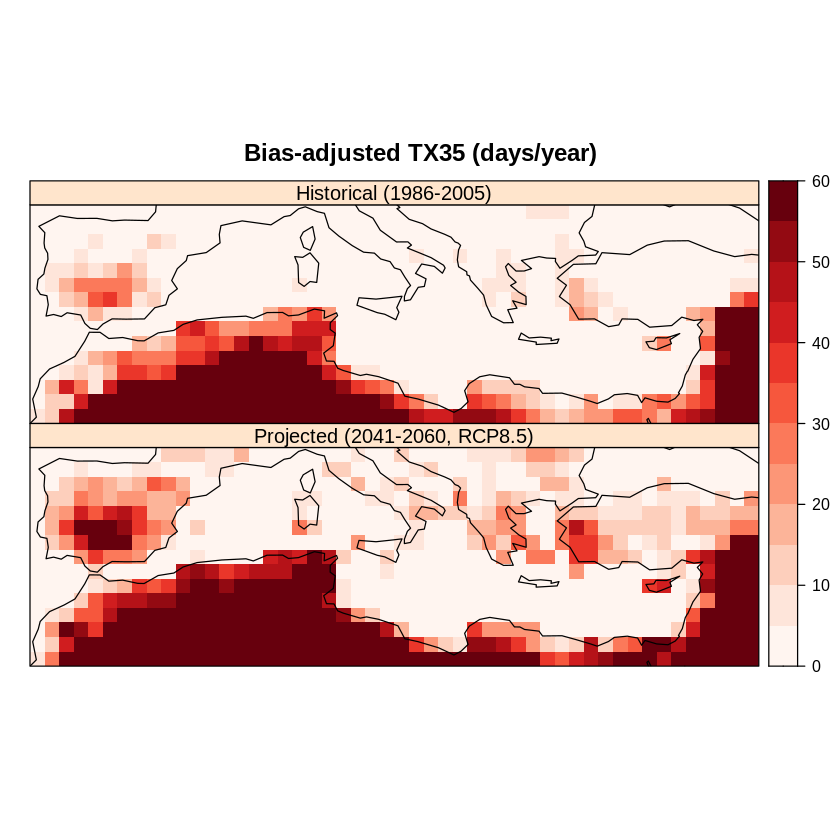

In [25]:
spatialPlot(makeMultiGrid(tx35.hist, tx35.rcp, skip.temporal.check=TRUE), backdrop.theme="coastline", 
            color.them="Reds", names.attr=c("Historical (1986-2005)","Projected (2041-2060, RCP8.5)"),
            main="Bias-adjusted TX35 (days/year)", as.table=TRUE, set.max=60, at=seq(0,60,5))

### Session Information

In [26]:
sessionInfo()

R version 3.6.3 (2020-02-29)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 18.04.5 LTS

Matrix products: default
BLAS/LAPACK: /home/ana/Appz/miniconda3/envs/notebooks-atlas/lib/libopenblasp-r0.3.15.so

locale:
 [1] LC_CTYPE=en_US.UTF-8          LC_NUMERIC=C                 
 [3] LC_TIME=es_ES.UTF-8           LC_COLLATE=en_US.UTF-8       
 [5] LC_MONETARY=es_ES.UTF-8       LC_MESSAGES=en_US.UTF-8      
 [7] LC_PAPER=es_ES.UTF-8          LC_NAME=es_ES.UTF-8          
 [9] LC_ADDRESS=es_ES.UTF-8        LC_TELEPHONE=es_ES.UTF-8     
[11] LC_MEASUREMENT=es_ES.UTF-8    LC_IDENTIFICATION=es_ES.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] rgdal_1.5-16            sp_1.4-5                visualizeR_1.6.0       
 [4] climate4R.indices_0.1.0 downscaleR_3.3.2        transformeR_2.1.0      
 [7] loadeR_1.7.0            climate4R.UDG_0.2.2     loadeR.java_1.1.1      
[10] rJava_1.0-4          

### References

* Bedia, J., Baño-Medina, J., Legasa, M.N., Iturbide, M., Manzanas, R., Herrera, S., Casanueva, A., San-Martín, D., Cofiño, A.S. and Gutiérrez, J.M. (2020) Statistical downscaling with the downscaleR package (v3.1.0): contribution to the VALUE intercomparison experiment. Geoscientific Model Developmen, 13, 1711–1735.
https://doi.org/10.5194/gmd-13-1711-2020.
* Bivand R.S., Keitt T., Rowlingson B. (2018). rgdal: Bindings for the ‘Geospatial’ Data Abstraction Library. R package version 1.3-6. https://CRAN.R-project.org/package=rgdal
*  Casanueva, A, Herrera, S, Iturbide, M, et al. (2020) Testing bias adjustment methods for regional climate change applications under observational uncertainty and resolution mismatch. Atmos Sci Lett. 21: 21:e978. https://doi.org/10.1002/asl.978
* Frías, M.D., Iturbide, M., Manzanas, R., Bedia, J., Fernández, J., Herrera, S., Cofiño, A.S., Gutiérrez, J.M. (2018). An R package to visualize and communicate uncertainty in seasonal climate prediction. Environ. Model. Software 99, 101–110. https://doi.org/10.1016/j.envsoft.2017.09.008.
* Iturbide, M., Bedia, J., Herrera, S., Baño-Medina, J., Fernández, J., Frías, M. D., Manzanas, R., San-Martín, D., Cimadevilla, E., Cofiño, A. S., and Gutiérrez, J. M. (2019) The R-based climate4R open framework for reproducible climate data access and post-processing, Environ. Modell. Softw., 111, 42–54,
https://doi.org/10.1016/j.envsoft.2018.09.009.
* Iturbide, M., Gutiérrez, J. M., Alves, L. M., Bedia, J., Cerezo-Mota, R., Cimadevilla, E., Cofiño, A. S., Di Luca, A., Faria, S. H., Gorodetskaya, I. V., Hauser, M., Herrera, S., Hennessy, K., Hewitt, H. T., Jones, R. G., Krakovska, S., Manzanas, R., Martínez-Castro, D., Narisma, G. T., Nurhati, I. S., Pinto, I., Seneviratne, S. I., van den Hurk, B., and Vera, C. S. (2020) An update of IPCC climate reference regions for subcontinental analysis of climate model data: definition and aggregated datasets, Earth Syst. Sci. Data, 12, 2959–2970, https://doi.org/10.5194/essd-12-2959-2020. 
* Lange, S. (2019) Trend-preserving bias adjustment and statistical downscaling with ISIMIP3BASD (v1.0). Geoscientific Model Development, 12, 3055–3070. https://doi.org/10.5194/gmd-12-3055-2019.
